# Pet's Faces Dataset

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [1]:
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2022-05-20 20:43:29--  https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-gzip]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M  9.81MB/s    in 2.4s    

2022-05-20 20:43:32 (9.81 MB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



Для визуализации списка изображений можно использовать такую функцию:

In [3]:
gpu_available = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(gpu_available))

Num GPUs: 1


In [4]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(l, titles=None,fontsize=50, bs = 5):
    n = min(bs, 5)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        if i == n:
          break
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()


In [5]:
batch_size = 5
img_size = (128, 128)

data_gen_aug = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., validation_split = 0.2, rotation_range = 30, horizontal_flip = True, zoom_range = 0.2, brightness_range = [0.5, 1])
data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., validation_split=0.2)

train_data = data_gen_aug.flow_from_directory("/content/petfaces", batch_size = batch_size, target_size = img_size,  subset = "training", seed = 20, class_mode = 'categorical', shuffle = True)
test_data = data_gen.flow_from_directory("/content/petfaces", batch_size = batch_size, target_size = img_size, subset = "validation", seed = 20, class_mode = 'categorical', shuffle = False)


Found 2583 images belonging to 35 classes.
Found 628 images belonging to 35 classes.


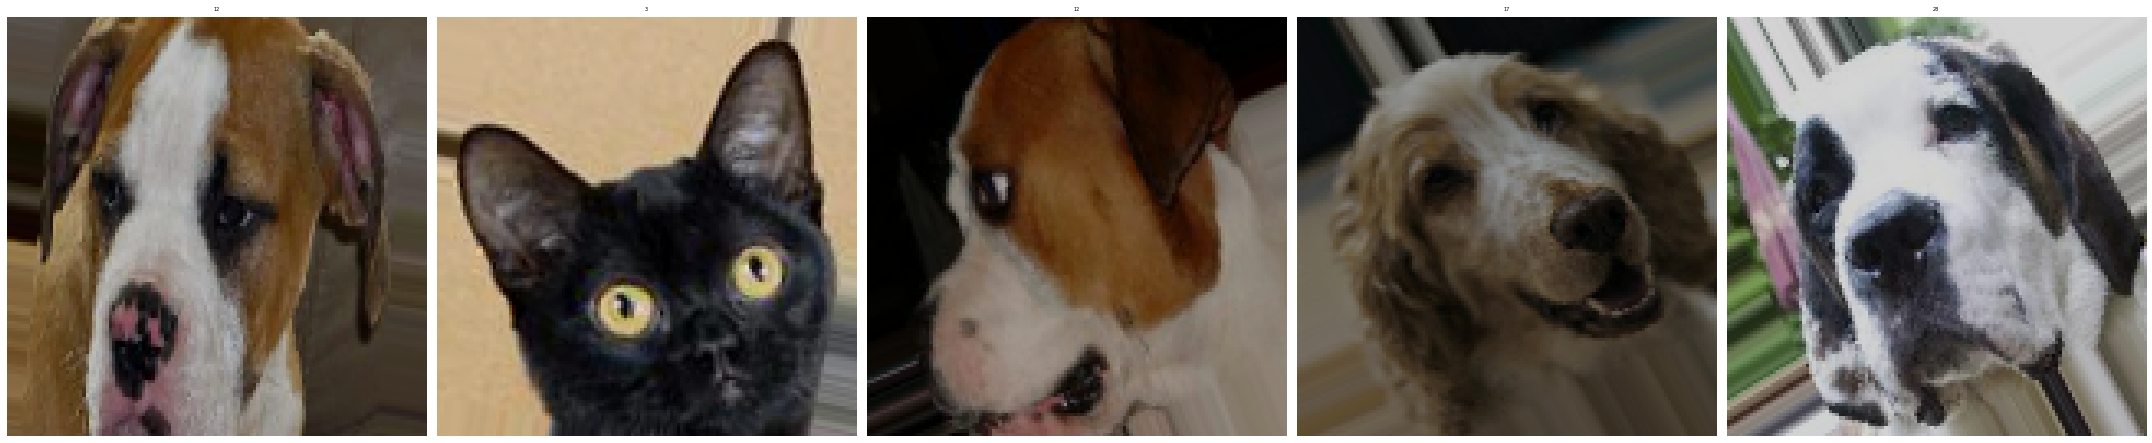

In [6]:
display_images(train_data[0][0], np.argmax(train_data[0][1], axis = 1), batch_size)

In [7]:
from keras.layers import *

model = keras.models.Sequential()

model.add(Conv2D(32, (15, 15), input_shape=(128, 128, 3), activation='tanh'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D())
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="tanh"))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1024,  activation="tanh"))
model.add(Dense(1024,  activation="tanh"))
model.add(Dense(512,  activation="tanh"))
model.add(Dense(35, activation='softmax'))

model.compile(tf.keras.optimizers.Adam(0.0001), 'categorical_crossentropy', ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(3)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 114, 114, 32)      21632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 26, 26, 128)       8320      
                                                                 
 dense_1 (Dense)             (None, 26, 26, 128)       1

In [8]:
hits = model.fit_generator(train_data, validation_data = test_data, epochs = 15)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


517/517 [==============================] - 30s 35ms/step - loss: 3.2843 - accuracy: 0.1057 - top_k_categorical_accuracy: 0.2451 - val_loss: 2.6628 - val_accuracy: 0.2468 - val_top_k_categorical_accuracy: 0.5191
Epoch 2/15
517/517 [==============================] - 18s 35ms/step - loss: 2.5508 - accuracy: 0.2818 - top_k_categorical_accuracy: 0.5114 - val_loss: 2.2332 - val_accuracy: 0.3408 - val_top_k_categorical_accuracy: 0.5955
Epoch 3/15
517/517 [==============================] - 19s 37ms/step - loss: 2.1643 - accuracy: 0.3686 - top_k_categorical_accuracy: 0.6341 - val_loss: 2.0709 - val_accuracy: 0.4061 - val_top_k_categorical_accuracy: 0.6576
Epoch 4/15
517/517 [==============================] - 18s 35ms/step - loss: 1.9285 - accuracy: 0.4204 - top_k_categorical_accuracy: 0.6918 - val_loss: 1.8255 - val_accuracy: 0.4650 - val_top_k_categorical_accuracy: 0.7341
Epoch 5/15
517/517 [==============================] - 18s 35ms/step - loss: 1.7298 - accuracy: 0.4824 - top_k_categorical_a

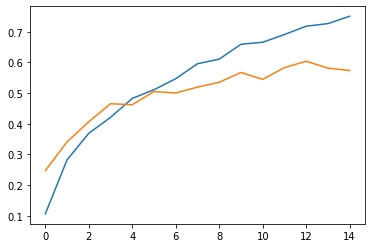

In [9]:
plt.plot(hits.history['accuracy'])
plt.plot(hits.history['val_accuracy'])

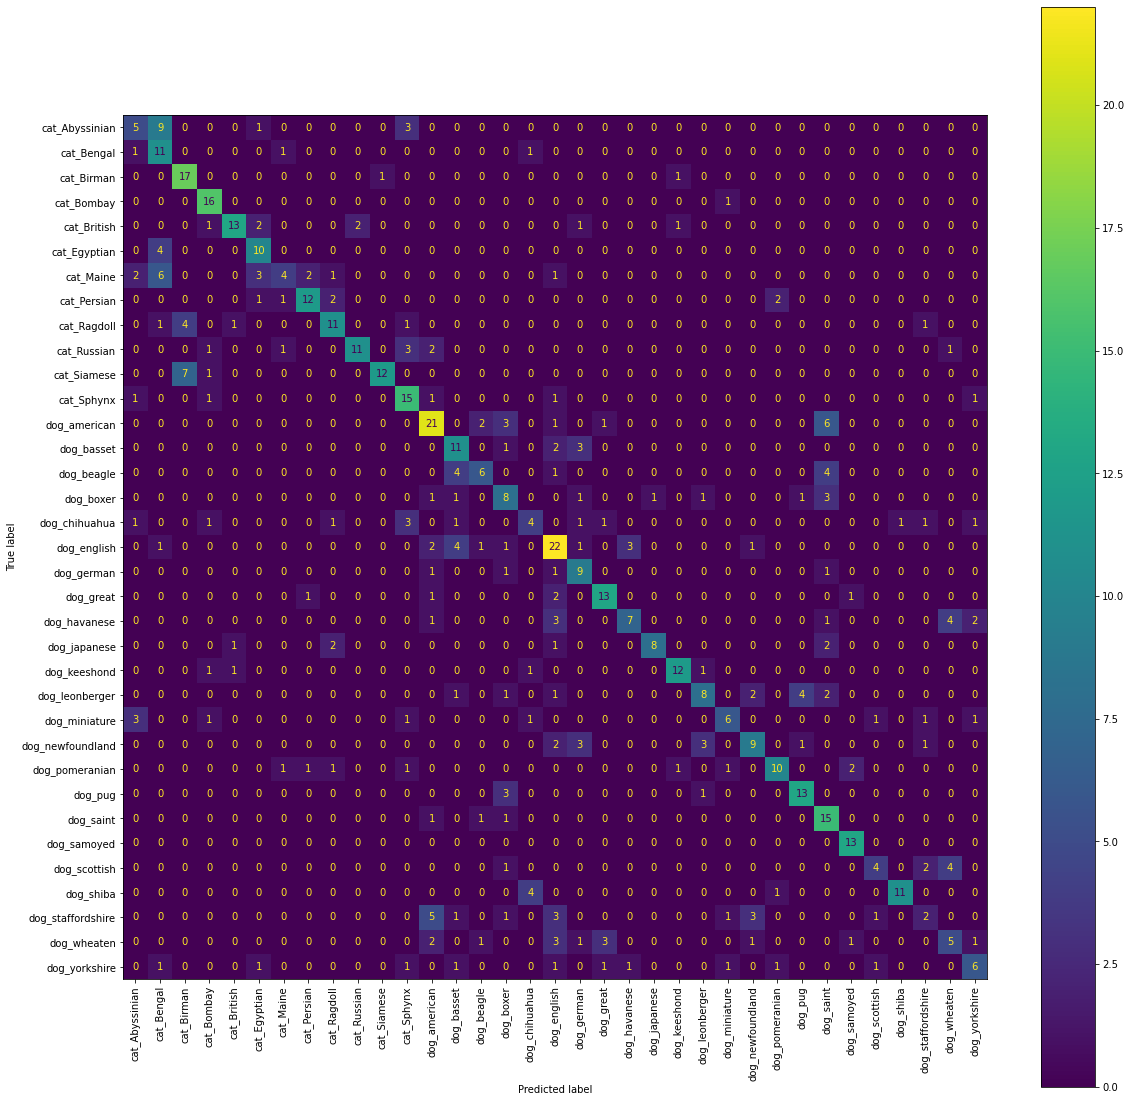

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

n_batches = len(test_data)
lablesNames = ['cat_Abyssinian', 'cat_Bengal', 'cat_Birman', 'cat_Bombay', 
               'cat_British', 'cat_Egyptian', 'cat_Maine', 'cat_Persian', 
               'cat_Ragdoll', 'cat_Russian', 'cat_Siamese', 'cat_Sphynx',
               'dog_american', 'dog_basset', 'dog_beagle', 'dog_boxer', 
               'dog_chihuahua', 'dog_english', 'dog_german', 'dog_great', 
               'dog_havanese', 'dog_japanese', 'dog_keeshond', 'dog_leonberger', 
               'dog_miniature', 'dog_newfoundland', 'dog_pomeranian', 'dog_pug', 
               'dog_saint', 'dog_samoyed', 'dog_scottish', 'dog_shiba', 
               'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire']


test_labels = np.concatenate([np.argmax(test_data[i][1], axis = 1) for i in range(n_batches)])    
predictions = np.argmax(model.predict(test_data, steps = n_batches), axis=1) 

cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                               display_labels = lablesNames)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_axes([0, 0, 1.5, 1.5])

disp.plot(ax = ax, xticks_rotation='vertical')
plt.show()

Точность для классификации "Кошка-собака"

In [12]:
r = 0

test_labels = np.concatenate([np.argmax(test_data[i][1], axis = 1) for i in range(n_batches)])    
predictions = np.argmax(model.predict(test_data, steps = n_batches), axis=1) 

for i in range(len(test_labels)):
  if (test_labels[i] <= 12 and predictions[i] <= 12) or (test_labels[i] > 12 and predictions[i] > 12):
      r += 1

print("acc = {}".format( r / len(test_labels)))

r = 0

predictions = model.predict(test_data, steps = n_batches) 
indexes = np.argsort(-predictions, axis = 1)

for i in range(len(predictions)):
  if (((indexes[i][0] <= 12 or indexes[i][1] <= 12 or indexes[i][2] <= 12) and (test_labels[i] <=12)) or (indexes[i][0] > 12 or indexes[i][1] > 12 or indexes[i][2] > 12) and (test_labels[i] > 12)):
    r += 1;

print("top 3 acc = {}".format( r / len(test_labels)))


acc = 0.8980891719745223
top 3 acc = 0.9792993630573248
